# Generate plots for tedana workflow
This notebook relies on outputs generated by the full tedana workflow. Some outputs needed to be added in specifically for these figures. The input data is a five-echo run of resting state data with 160 TRs, which has been preprocessed (slice timing correction and motion correction), but which has not been warped to standard space.

Here is the command run:

```
tedana -d /Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/p06.SBJ01_S09_Task11_e1.sm.nii.gz /Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/p06.SBJ01_S09_Task11_e2.sm.nii.gz /Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/p06.SBJ01_S09_Task11_e3.sm.nii.gz /Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/p06.SBJ01_S09_Task11_e4.sm.nii.gz /Users/tsalo/Documents/tsalo/tedana_comparison/e5_data/p06.SBJ01_S09_Task11_e5.sm.nii.gz -e 15.4 29.7 44.0 58.3 72.6 --label mlepca --no_gscontrol
```

MLEPCA was *not* used for PCA dimensionality estimation (# components retained with MLEPCA = 159, the max number, so no whitening occurs). Instead, SVD + the decision tree was used. Scikit-learn's FastICA was used for ICA, and the Kundu v3.2 algorithm was used to classify ICA components.

In [2]:
%matplotlib inline
import os.path as op
from glob import glob

import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from nilearn.masking import apply_mask
from sklearn.decomposition import PCA, FastICA

## Load data

In [5]:
base_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/'
data_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e5_data/'
mask_file = op.join(base_dir, 'current/mask.nii')
echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

# Raw data (after STC and MC)
files = sorted(glob(op.join(data_dir, '*.nii.gz')))

masked_data = [apply_mask(f, mask_file) for f in files]
masked_data = np.stack(masked_data)
masked_data = np.swapaxes(np.swapaxes(masked_data, 0, 2), 1, 2)

# Optimally combined data
oc_file_t2s = op.join(base_dir, 'current/ts_OC.nii')
oc_file_lin = op.join(base_dir, 'current-dectree-linear/ts_OC.nii')

oc_t2s = apply_mask(oc_file_t2s, mask_file)
oc_z_t2s = (oc_t2s - np.mean(oc_t2s, axis=0)) / np.std(oc_t2s, axis=0)

oc_lin = apply_mask(oc_file_lin, mask_file)
oc_z_lin = (oc_lin - np.mean(oc_lin, axis=0)) / np.std(oc_lin, axis=0)

# Select voxel with block-ish timeseries
voxel_idx = 14501  # corresponds to 22, 47, 2
mask_img = nib.load(mask_file)
temp_data = np.zeros(mask_img.shape)
temp_data[22, 47, 2] = 1
temp_img = nib.Nifti1Image(temp_data, mask_img.affine)
temp_data = apply_mask(temp_img, mask_img)
voxel_idx = np.where(temp_data == 1)[0][0]

ValueError: File not found: '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/current/mask.nii'

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


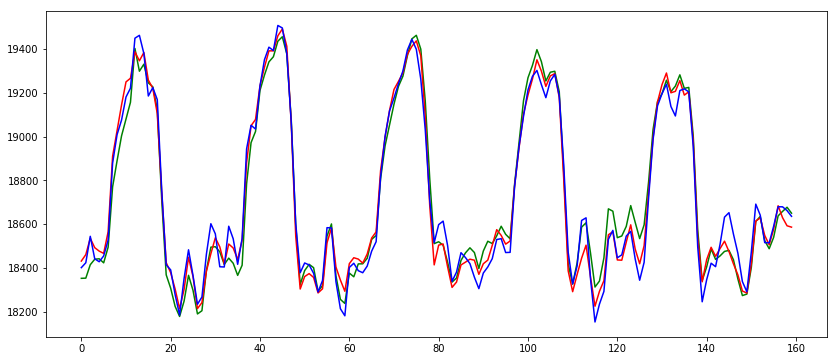

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

f = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/TED.p06.mlepca/ts_OC.nii'
td = apply_mask(f, mask_img)
td = td[:, voxel_idx]
ax.plot(td, color='green')

f = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/TED.p06.mlepca/dn_ts_OC.nii'
td = apply_mask(f, mask_img)
td = td[:, voxel_idx]
ax.plot(td, color='red')

f = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/TED.p06.mlepca/dn_ts_OC_T1c.nii'
td = apply_mask(f, mask_img)
td = td[:, voxel_idx]
ax.plot(td, color='blue')

fig.show()

In [9]:
temp_img.to_filename('/Users/tsalo/Desktop/THING.nii.gz')

## Multi-Echo Principal Components Analysis
Optimally combined data are decomposed with PCA.
The PCA components are selected according to one of multiple possible approaches.
Two possible approaches are a decision tree and a threshold using the percentage of variance explained by each component.

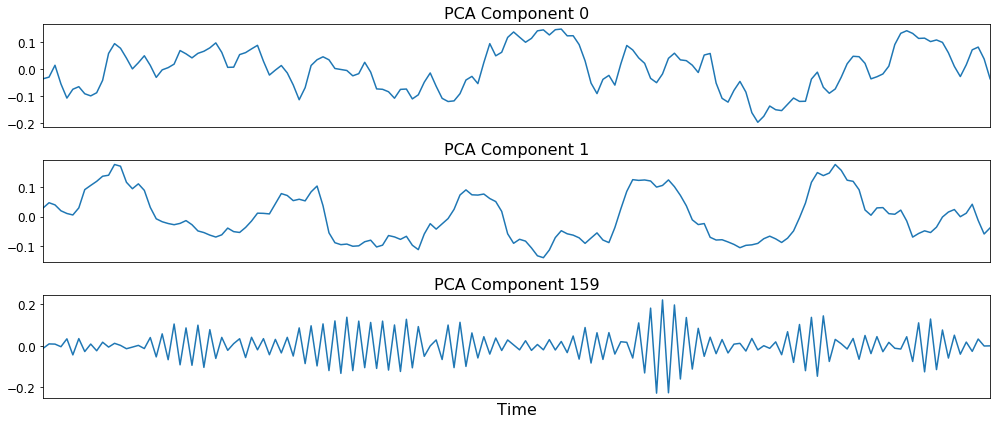

In [3]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(mepca_mmix[:, 0])
axes[0].set_title('PCA Component 0', fontsize=16)
axes[1].plot(mepca_mmix[:, 1])
axes[1].set_title('PCA Component 1', fontsize=16)
axes[2].plot(mepca_mmix[:, -1])
axes[2].set_title('PCA Component {}'.format(mepca_mmix.shape[0]-1), fontsize=16)
axes[0].set_xlim(0, mepca_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig('11_pca_component_timeseries.png', dpi=400)

# Data Whitening
The selected components from the PCA are recombined to produce a whitened version of the optimally combined data.

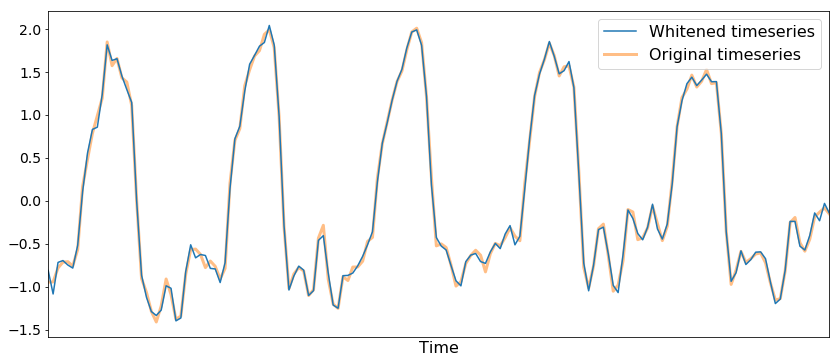

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(oc_red[:, voxel_idx], label='Whitened timeseries', zorder=1.)
ax.plot(oc_z[:, voxel_idx], label='Original timeseries', alpha=0.5, zorder=0., linewidth=3)
legend = ax.legend(frameon=True, fontsize=16)
ax.set_xlim(0, oc_z.shape[0]-1)
ax.set_xticks([])
ax.set_xlabel('Time', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('12_pca_whitened_data.png', dpi=400)

## Multi-Echo Independent Components Analysis
The whitened optimally combined data are then decomposed with ICA. The number of ICA components is limited to the number of retained components from the PCA, in order to reflect the true dimensionality of the data.
ICA produces a mixing matrix (i.e., timeseries for each component).

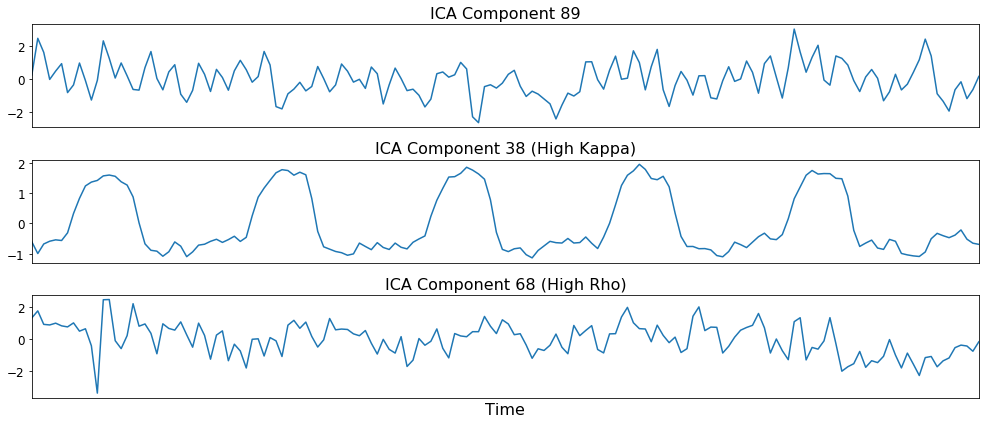

In [5]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(meica_mmix[:, 89])
axes[0].set_title('ICA Component 89', fontsize=16)
axes[1].plot(meica_mmix[:, 38])
axes[1].set_title('ICA Component 38 (High Kappa)', fontsize=16)
axes[2].plot(meica_mmix[:, 68])
axes[2].set_title('ICA Component 68 (High Rho)', fontsize=16)
axes[0].set_xlim(0, meica_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig('13_ica_component_timeseries.png', dpi=400)

# $R_2$ and $S_0$ Model Fit
Linear regression is used to fit the component timeseries to each voxel in each echo from the original, echo-specific data. This results in echo- and voxel-specific betas for each of the components. TE-dependence ($R_2$) and TE-independence ($S_0$) models can then be fit to these betas.

These models allow calculation of F-statistics for the $R_2$ and $S_0$ models (referred to as $\kappa$ and $\rho$, respectively).

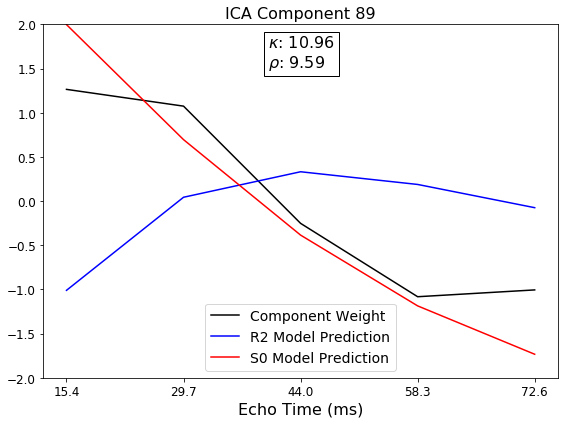

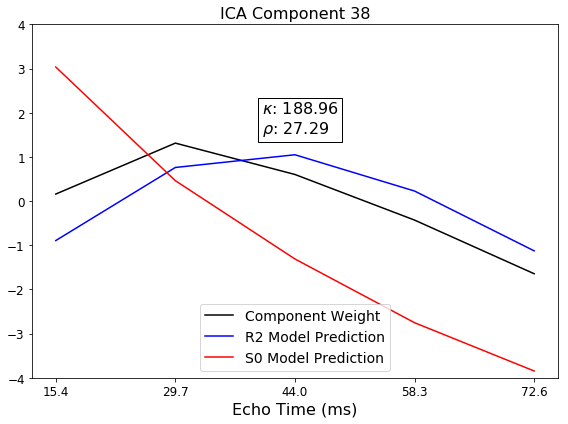

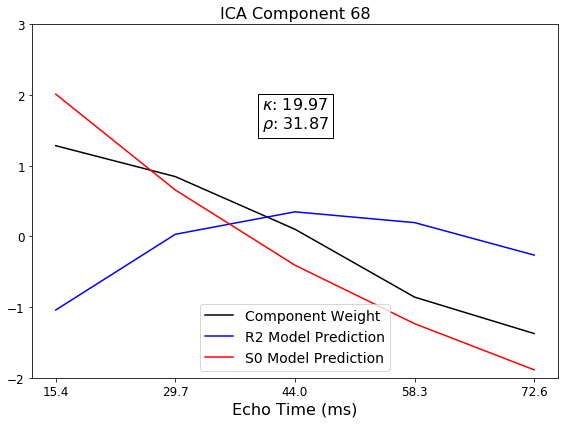

In [6]:
for i, comp in enumerate([89, 38, 68]):  # only generate plots for a few components
    # Use weight map to average as fitmodels_direct does
    comp_weights = np.average(meica_betas[comp, :, :], weights=norm_weights[comp, :], axis=1)
    r2_pred_weights = np.average(r2_pred_betas[comp, :, :], weights=norm_weights[comp, :], axis=1)
    s0_pred_weights = np.average(s0_pred_betas[comp, :, :], weights=norm_weights[comp, :], axis=1)
    kappa = np.average(meica_f_r2[comp, :], weights=norm_weights[comp, :])
    rho = np.average(meica_f_s0[comp, :], weights=norm_weights[comp, :])
    
    mean_ = np.mean(comp_weights)
    std_ = np.std(comp_weights)
    comp_weights_z = (comp_weights - mean_) / std_
    s0_pred_weights_z = (s0_pred_weights - mean_) / std_
    r2_pred_weights_z = (r2_pred_weights - mean_) / std_

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(echo_times, comp_weights_z, color='black', label='Component Weight')
    ax.plot(echo_times, r2_pred_weights_z, color='blue', label='R2 Model Prediction')
    ax.plot(echo_times, s0_pred_weights_z, color='red', label='S0 Model Prediction')
    ax.set_xticks(echo_times)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Echo Time (ms)', fontsize=16)
    temp = np.hstack((comp_weights_z, s0_pred_weights_z, r2_pred_weights_z))
    ax.set_ylim(np.floor(np.min(temp)), np.ceil(np.max(temp)))
    legend = ax.legend(frameon=True, loc='lower center', fontsize=14)
    ax.set_title('ICA Component {}'.format(comp), fontsize=16)
    ax.annotate('$\kappa$: {0:.02f}\n$\\rho$: {1:.02f}'.format(kappa, rho),
                xy=(40, 1.5), fontsize=16,
                bbox=dict(fc="white", ec="black", lw=1))
    fig.tight_layout()
    fig.savefig('14_te_dependence_models_component_{}.png'.format(i), dpi=400)

# ICA Component Selection and Multi-Echo Denoising
A decision tree is applied to $\kappa$, $\rho$, and other metrics in order to classify ICA components as TE-dependent (BOLD signal), TE-independent (non-BOLD noise), or neither (to be ignored).

The ICA components are fitted to the original (not whitened) optimally combined data with linear regression, which is used to weight the components for construction of the denoised data. The residuals from this regression will thus include the variance that was not included in the PCA-whitened optimally combined data.

The ME-DN dataset is constructed from the accepted (BOLD) and ignored components, as well as the residual variance not explained by the ICA.
The ME-HK dataset is constructed just from the accepted (BOLD) components. This means that ignored components and residual variance not explained by the ICA are not included in the resulting dataset.

No handles with labels found to put in legend.


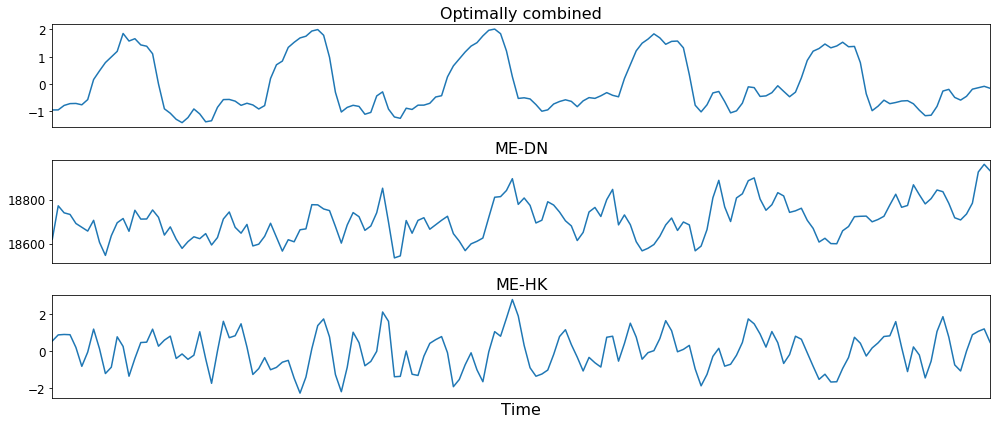

In [17]:
dn_data_z = (dn_data - np.mean(dn_data, axis=0)) / np.std(dn_data, axis=0)
hk_data_z = (hk_data - np.mean(hk_data, axis=0)) / np.std(hk_data, axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(oc_z[:, voxel_idx], label='Optimally combined')
axes[0].set_title('Optimally combined', fontsize=16)

axes[1].plot(dn_data_z[:, voxel_idx], label='ME-DN')
axes[1].set_title('ME-DN', fontsize=16)

axes[2].plot(hk_data_z[:, voxel_idx])
axes[2].set_title('ME-HK', fontsize=16)
legend = ax.legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()

fig.savefig('15_denoised_data_timeseries.png', dpi=400)

# Post-processing to remove spatially diffuse noise
Due to the constraints of ICA, MEICA is able to identify and remove spatially localized noise components, but it cannot identify components that are spread out throughout the whole brain.

One of several post-processing strategies may be applied to the ME-DN or ME-HK datasets in order to remove spatially diffuse (ostensibly respiration-related) noise. Methods which have been employed in the past include global signal regression (GSR), T1c-GSR, anatomical CompCor, Go Decomposition (GODEC), and robust PCA.

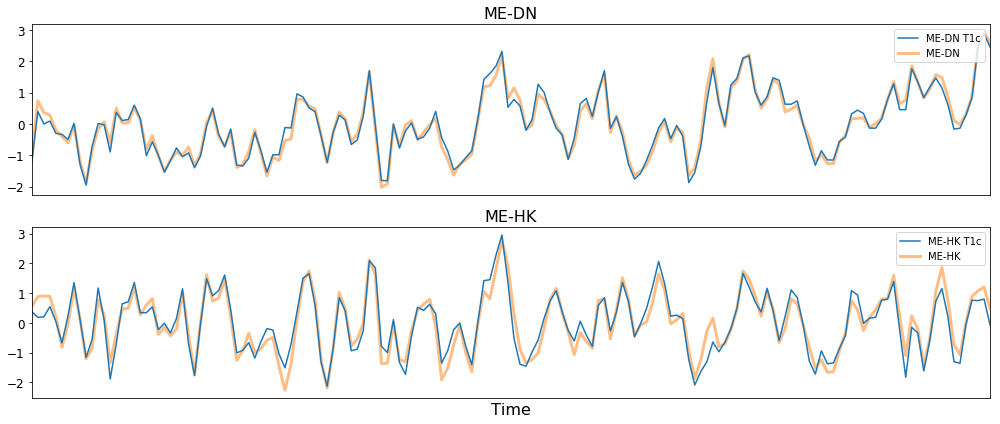

In [8]:
dn_t1c_data_z = (dn_t1c_data - np.mean(dn_t1c_data, axis=0)) / np.std(dn_t1c_data, axis=0)
hk_t1c_data_z = (hk_t1c_data - np.mean(hk_t1c_data, axis=0)) / np.std(hk_t1c_data, axis=0)

fig, axes = plt.subplots(2, sharex=True, figsize=(14, 6))
axes[0].plot(dn_t1c_data_z[:, voxel_idx], label='ME-DN T1c')
axes[0].plot(dn_data_z[:, voxel_idx], label='ME-DN', alpha=0.5, linewidth=3, zorder=0.)
axes[0].set_title('ME-DN', fontsize=16)
legend = axes[0].legend(frameon=True, loc='upper right')

axes[1].plot(hk_t1c_data_z[:, voxel_idx], label='ME-HK T1c')
axes[1].plot(hk_data_z[:, voxel_idx], label='ME-HK', alpha=0.5, linewidth=3, zorder=0.)
axes[1].set_title('ME-HK', fontsize=16)
legend = axes[1].legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[1].set_xticks([])
axes[1].set_xlabel('Time', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
fig.savefig('16_t1c_denoised_data_timeseries.png', dpi=400)